In [1]:
from pathlib import Path
from tqdm import tqdm
from virtualizarr import open_virtual_dataset, open_virtual_mfdataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
from icechunk.xarray import to_icechunk
from dask.diagnostics import ProgressBar

import obstore as obs
import xarray as xr
import icechunk
import hvplot.xarray
import xclim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(
  "ignore",
  message="Numcodecs codecs are not in the Zarr version 3 specification*",
  category=UserWarning
)
icechunk.set_logs_filter(
    "icechunk::storage::object_store=error"
)  # remove the warning due to the local icechunk store

In [2]:
ROOT_DIR = Path("/Volumes/T7")
RAW_FILES_DIR = ROOT_DIR / "raw_files/hackathon-meteo-france"

BUCKETS_DIR = ROOT_DIR / "buckets"
ICECHUNK_BUCKET = BUCKETS_DIR / "hackathon-meteo-france"
PREFIX_ANASTASIA = "REA/ANASTASIA"
PREFIX_RCM = "RCM"

PREFIX_PROCESSED_OBS = "processed/observations"
PREFIX_PROCESSED_INDICATORS = "processed/observations"

prefix = "file:///Volumes/"

# Storage

In [3]:
storage = icechunk.local_filesystem_storage(
    # optional: we can add a prefix here
    path=ICECHUNK_BUCKET / PREFIX_RCM
)
new_repo = icechunk.Repository.open(
    storage,
    authorize_virtual_chunk_access={prefix: None}
)
new_session = new_repo.readonly_session("main")

dt = xr.open_datatree(new_session.store, engine='zarr', zarr_format=3, chunks={})
dt

<xarray.DataTree>
Group: /
├── Group: /hussAdjust
│       Dimensions:                      (source_id: 17, time: 23376, y: 134, x: 143)
│       Coordinates:
│         * source_id                    (source_id) object 136B 'EC-Earth3:r1i1p1f1:...
│         * time                         (time) datetime64[ns] 187kB 1951-01-01T12:00...
│         * y                            (y) float64 1kB 1.617e+06 ... 2.681e+06
│         * x                            (x) float64 1kB 6e+04 6.8e+04 ... 1.196e+06
│           lon                          (y, x) float64 153kB dask.array<chunksize=(134, 143), meta=np.ndarray>
│           input_driving_variant_label  (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│           input_driving_source_id      (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│           lat                          (y, x) float64 153kB dask.array<chunksize=(134, 143), meta=np.ndarray>
│           input_source_id              (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│       Data variables:
│           LambertParisII               (source_id) int32 68B dask.array<chunksize=(1,), meta=np.ndarray>
│           hussAdjust                   (source_id, time, y, x) float32 30GB dask.array<chunksize=(1, 128, 134, 143), meta=np.ndarray>
│       Attributes: (12/51)
│           summary:                         Data were post-processed by the Météo-Fr...
│           Conventions:                     CF-1.11 ACDD-1.3
│           standard_name_vocabulary:        CF Standard Name Table v81
│           input_domain:                    Europe
│           input_domain_id:                 EUR-12
│           project:                         Socle-FR-Metro-Climat-2025
│           ...                              ...
│           time_coverage_duration:          P1Y
│           time_coverage_resolution:        P1D
│           product:                         bias-adjusted output
│           product_version:                 v1
│           comment:                         Preliminary data released in the Fall 20...
│           keywords:                        humidity, climate, France, near-surface ...
├── Group: /tasminAdjust
│       Dimensions:                      (source_id: 17, time: 23376, y: 134, x: 143)
│       Coordinates:
│         * source_id                    (source_id) object 136B 'EC-Earth3:r1i1p1f1:...
│         * time                         (time) datetime64[ns] 187kB 1951-01-01T12:00...
│         * y                            (y) float64 1kB 1.617e+06 ... 2.681e+06
│         * x                            (x) float64 1kB 6e+04 6.8e+04 ... 1.196e+06
│           input_driving_variant_label  (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│           lat                          (y, x) float64 153kB dask.array<chunksize=(134, 143), meta=np.ndarray>
│           input_source_id              (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│           lon                          (y, x) float64 153kB dask.array<chunksize=(134, 143), meta=np.ndarray>
│           input_driving_source_id      (source_id) object 136B dask.array<chunksize=(17,), meta=np.ndarray>
│       Data variables:
│           tasminAdjust                 (source_id, time, y, x) float32 30GB dask.array<chunksize=(1, 128, 134, 143), meta=np.ndarray>
│           LambertParisII               (source_id) int32 68B dask.array<chunksize=(1,), meta=np.ndarray>
│       Attributes: (12/50)
│           Conventions:                     CF-1.11 ACDD-1.3
│           standard_name_vocabulary:        CF Standard Name Table v81
│           input_domain:                    Europe
│           input_domain_id:                 EUR-12
│           project:                         Socle-FR-Metro-Climat-2025
│           grid_resolution:                 8-km
│           ...                              ...
│           time_coverage_duration:          P1Y
│           time_coverage_res

In [4]:
list(dt.children)

['hussAdjust',
 'tasminAdjust',
 'sfcWindAdjust',
 'tasAdjust',
 'prAdjust',
 'tasmaxAdjust']

In [6]:
def save_dataset(ds: xr.Dataset, repo: icechunk.Repository, path: str):
    session = repo.writable_session("main")
    with ProgressBar():
        to_icechunk(ds, session, group=path)
    msg = f"Import dataset {path}"
    snapshot = session.commit(msg)
    print(f"{snapshot} - {msg}")


In [5]:
repo_indicators = icechunk.Repository.open_or_create(
    icechunk.local_filesystem_storage(
        # optional: we can add a prefix here
        path=ICECHUNK_BUCKET / PREFIX_PROCESSED_INDICATORS
    ),
    authorize_virtual_chunk_access={prefix: None}
)

# RCMs

## Compute `hurs`

In [8]:
ps = xr.DataArray(data=101325, attrs=dict(units="Pa", standard_name="surface_air_pressure"))

In [9]:
ps

<xarray.DataArray ()> Size: 8B
array(101325)
Attributes:
    units:          Pa
    standard_name:  surface_air_pressure

In [10]:
hurs = xclim.indicators.convert.relative_humidity(
    tas=dt["tasAdjust"].tasAdjust,
    huss=dt["hussAdjust"].hussAdjust,
    ps=ps
)

## Compute heat index

In [11]:
heat_index = xclim.indicators.convert.heat_index(
    tas=dt["tasAdjust"].tasAdjust,
    hurs=hurs,
)

In [15]:
save_dataset(ds=heat_index.to_dataset(), repo=repo_indicators, path="daily/heat_index")

[########################################] | 100% Completed | 150.89 s
CK8YD3AZ8MXZT8NB5TA0 - Import dataset daily/heat_index


## Fire weather indicator

In [17]:
x = xclim.indicators.atmos.cffwis_indices(
    tas=dt["tasAdjust"].tasAdjust,
    pr=dt["prAdjust"].prAdjust,
    sfcWind=dt["sfcWindAdjust"].sfcWindAdjust,
    hurs=hurs,
    lat=dt["tasAdjust"].lat,
)

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

# Anastasia

In [ ]:
def fix_anastasia_dataset(x):
    full_years = pd.date_range(x.time.to_index()[0],
                               x.time.to_index()[-1],
                               freq="D")
    x = x.reindex(time=full_years)
    return x

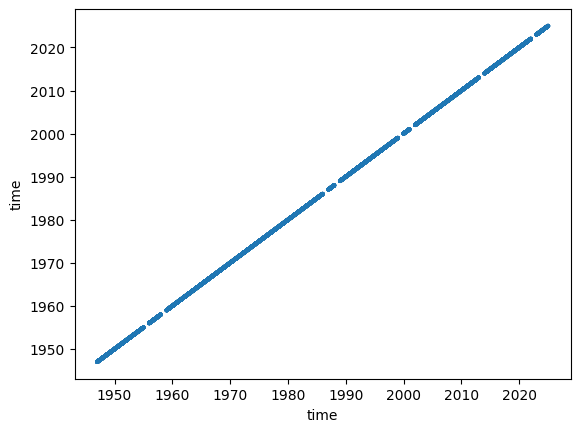

In [13]:
dt["tas"].tas.time.plot.scatter(marker=".", edgecolor="none")
plt.show()

In [30]:
x = dt["tasmax"].tasmax

In [31]:
full_years = pd.date_range(x.time.to_index()[0],
                           x.time.to_index()[-1],
                           freq="D")
x = x.reindex(time=full_years)

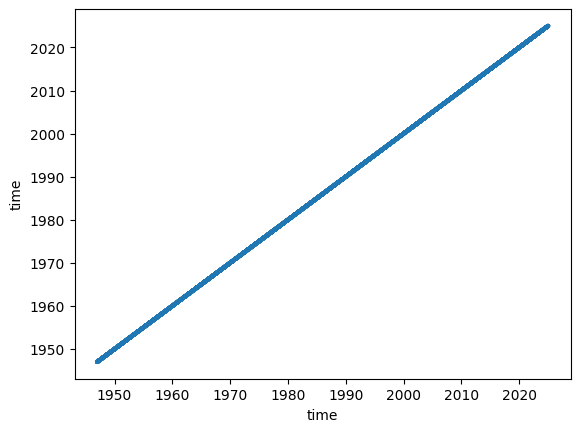

In [32]:
x.time.plot.scatter(marker=".", edgecolor="none")
plt.show()

In [33]:
x.time

<xarray.DataArray 'time' (time: 28490)> Size: 228kB
array(['1947-01-01T00:00:00.000000000', '1947-01-02T00:00:00.000000000',
       '1947-01-03T00:00:00.000000000', ..., '2024-12-29T00:00:00.000000000',
       '2024-12-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
      shape=(28490,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 228kB 1947-01-01 1947-01-02 ... 2024-12-31
Attributes:
    long_name:      time
    axis:           T
    standard_name:  time

In [36]:
y = xclim.indicators.atmos.tx_days_above(tasmax=x, thresh="35.0 degC")

with ProgressBar():
    y = y.compute()

/Users/alexandre/dev/work/azard/hacking-around/hackathon-meteo-france/.venv/lib/python3.12/site-packages/xclim/core/cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])


[########################################] | 100% Completed | 143.72 s


In [44]:
y.time

<xarray.DataArray 'time' (time: 78)> Size: 624B
array(['1947-01-01T00:00:00.000000000', '1948-01-01T00:00:00.000000000',
       '1949-01-01T00:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '1951-01-01T00:00:00.000000000', '1952-01-01T00:00:00.000000000',
       '1953-01-01T00:00:00.000000000', '1954-01-01T00:00:00.000000000',
       '1955-01-01T00:00:00.000000000', '1956-01-01T00:00:00.000000000',
       '1957-01-01T00:00:00.000000000', '1958-01-01T00:00:00.000000000',
       '1959-01-01T00:00:00.000000000', '1960-01-01T00:00:00.000000000',
       '1961-01-01T00:00:00.000000000', '1962-01-01T00:00:00.000000000',
       '1963-01-01T00:00:00.000000000', '1964-01-01T00:00:00.000000000',
       '1965-01-01T00:00:00.000000000', '1966-01-01T00:00:00.000000000',
       '1967-01-01T00:00:00.000000000', '1968-01-01T00:00:00.000000000',
       '1969-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
       '1971-01-01T00:00:00.000000000', '1972-01-01T00:00:00.000000000',
       '1973-01-01T00:00:00.000000000', '1974-01-01T00:00:00.000000000',
       '1975-01-01T00:00:00.000000000', '1976-01-01T00:00:00.000000000',
       '1977-01-01T00:00:00.000000000', '1978-01-01T00:00:00.000000000',
       '1979-01-01T00:00:00.000000000', '1980-01-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1986-01-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1988-01-01T00:00:00.000000000',
       '1989-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1994-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1997-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '1999-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2007-01-01T00:00:00.000000000', '2008-01-01T00:00:00.000000000',
       '2009-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000', '2014-01-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000', '2024-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 624B 1947-01-01 1948-01-01 ... 2024-01-01
Attributes:
    long_name:      time
    axis:           T
    standard_name:  time

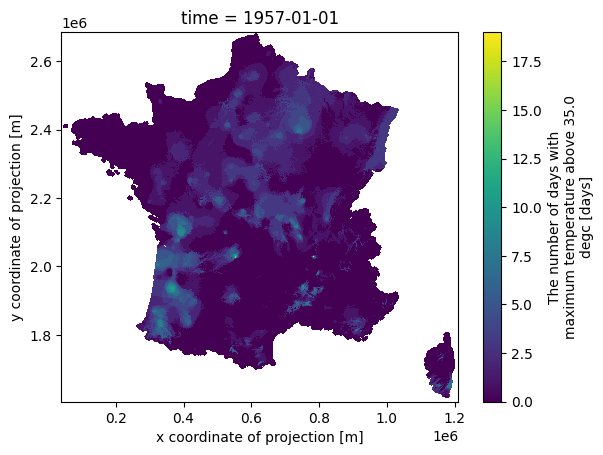

In [41]:
y.isel(time=10).plot()
plt.show()

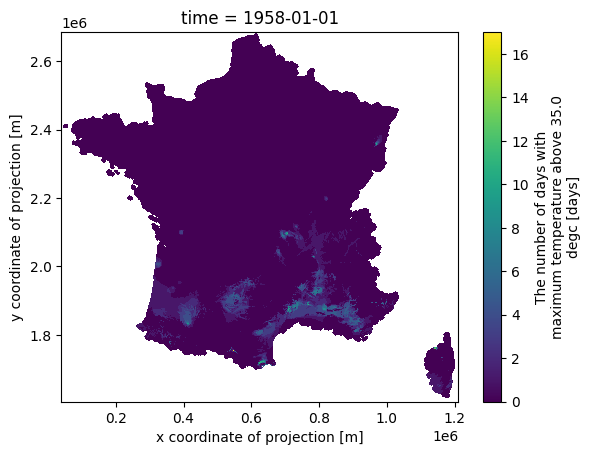

In [43]:
y.isel(time=11).plot()
plt.show()

In [ ]:
storage = icechunk.local_filesystem_storage(
    # optional: we can add a prefix here
    path=ICECHUNK_BUCKET / PREFIX_ANASTASIA
)
new_repo = icechunk.Repository.open(
    storage,
    authorize_virtual_chunk_access={prefix: None}
)
new_session = new_repo.readonly_session("main")

dt = xr.open_datatree(new_session.store, engine='zarr', zarr_format=3, chunks={})
dt